<a href="https://colab.research.google.com/github/qhfks27/rani01/blob/master/PPO_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda

import tensorflow as tf

class Actor(object):
    """
        Actor Network for PPO
    """
    def __init__(self, state_dim, action_dim, action_bound, learning_rate, ratio_clipping):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.ratio_clipping = ratio_clipping

        self.std_bound = [1e-2, 1.0] # std bound

        self.model = self.build_network()

        self.actor_optimizer = tf.keras.optimizers.Adam(self.learning_rate)

    ## actor network
    def build_network(self):
        state_input = Input((self.state_dim,))
        h1 = Dense(64, activation='relu')(state_input)
        h2 = Dense(32, activation='relu')(h1)
        h3 = Dense(16, activation='relu')(h2)
        out_mu = Dense(self.action_dim, activation='tanh')(h3)
        std_output = Dense(self.action_dim, activation='softplus')(h3)

        # Scale output to [-action_bound, action_bound]
        mu_output = Lambda(lambda x: x*self.action_bound)(out_mu)
        model = Model(state_input, [mu_output, std_output])
        model.summary()
        return model


    ## log policy pdf
    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        var = std**2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / var - 0.5 * tf.math.log(var * 2 * np.pi)
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)


    ## actor policy
    def get_policy_action(self, state):
        # type of action in env is numpy array
        # np.reshape(state, [1, self.state_dim]) : shape (state_dim,) -> shape (1, state_dim)
        # why [0]?  shape (1, action_dim) -> (action_dim,)
        mu_a, std_a = self.model.predict(np.reshape(state, [1, self.state_dim]))
        mu_a = mu_a[0]
        std_a = std_a[0]
        std_a = np.clip(std_a, self.std_bound[0], self.std_bound[1])
        action = np.random.normal(mu_a, std_a, size=self.action_dim)
        return mu_a, std_a, action

    ## actor prediction
    def predict(self, state):
        mu_a, _= self.model.predict(np.reshape(state, [1, self.state_dim]))
        return mu_a[0]


    ## train the actor network
    def train(self, log_old_policy_pdf, states, actions, advantages):
        with tf.GradientTape() as tape:
            # current policy pdf
            mu_a, std_a = self.model(states)
            log_policy_pdf = self.log_pdf(mu_a, std_a, actions)

            # ratio of current and old policies
            ratio = tf.exp(log_policy_pdf - log_old_policy_pdf)
            clipped_ratio = tf.clip_by_value(ratio, 1.0-self.ratio_clipping, 1.0+self.ratio_clipping)
            surrogate = -tf.minimum(ratio * advantages, clipped_ratio * advantages)
            loss = tf.reduce_mean(surrogate)
        dj_dtheta = tape.gradient(loss, self.model.trainable_variables)
        grads = zip(dj_dtheta, self.model.trainable_variables)
        self.actor_optimizer.apply_gradients(grads)

    ## save actor weights
    def save_weights(self, path):
        self.model.save_weights(path)


    ## load actor wieghts
    def load_weights(self, path):
        self.model.load_weights(path + 'pendulum_actor.h5')

In [2]:
# PPO with GAE Critic

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

class Critic(object):
    """
        Critic Network for PPO: V function approximator
    """
    def __init__(self, state_dim, action_dim, learning_rate):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate

        # create and compile critic network
        self.model, self.states = self.build_network()

        self.model.compile(optimizer=Adam(self.learning_rate), loss='mse')

    ## critic network
    def build_network(self):
        state_input = Input((self.state_dim,))
        h1 = Dense(64, activation='relu')(state_input)
        h2 = Dense(32, activation='relu')(h1)
        h3 = Dense(16, activation='relu')(h2)
        v_output = Dense(1, activation='linear')(h3)
        model = Model(state_input, v_output)
        model.summary()
        return model, state_input


    ## single gradient update on a single batch data
    def train_on_batch(self, states, td_targets):
        return self.model.train_on_batch(states, td_targets)


    ## save critic weights
    def save_weights(self, path):
        self.model.save_weights(path)


    ## load critic wieghts
    def load_weights(self, path):
        self.model.load_weights(path + 'pendulum_critic.h5')

In [3]:
# PPO with GAE Agent for training and evaluation

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


class PPOagent(object):

    def __init__(self, env):

        # hyperparameters
        self.GAMMA = 0.95
        self.GAE_LAMBDA = 0.9 #0.8
        self.BATCH_SIZE = 64
        self.ACTOR_LEARNING_RATE = 0.0001
        self.CRITIC_LEARNING_RATE = 0.001
        self.RATIO_CLIPPING = 0.2
        self.EPOCHS = 10

        self.env = env
        # get state dimension
        self.state_dim = env.observation_space.shape[0]
        # get action dimension
        self.action_dim = env.action_space.shape[0]
        # get action bound
        self.action_bound = env.action_space.high[0]

        # create actor and critic networks
        self.actor = Actor(self.state_dim, self.action_dim, self.action_bound,
                           self.ACTOR_LEARNING_RATE, self.RATIO_CLIPPING)
        self.critic = Critic(self.state_dim, self.action_dim, self.CRITIC_LEARNING_RATE)

        # save the results
        self.save_epi_reward = []


    ## computing Advantages and targets: y_k = r_k + gamma*V(s_k+1), A(s_k, a_k)= y_k - V(s_k)
    def gae_target(self, rewards, v_values, next_v_value, done):
        n_step_targets = np.zeros_like(rewards)
        gae = np.zeros_like(rewards)
        gae_cumulative = 0
        forward_val = 0

        if not done:
            forward_val = next_v_value

        for k in reversed(range(0, len(rewards))):
            delta = rewards[k] + self.GAMMA * forward_val - v_values[k]
            gae_cumulative = self.GAMMA * self.GAE_LAMBDA * gae_cumulative + delta
            gae[k] = gae_cumulative
            forward_val = v_values[k]
            n_step_targets[k] = gae[k] + v_values[k]
        return gae, n_step_targets


    ## convert (list of np.array) to np.array
    def unpack_batch(self, batch):
        unpack = batch[0]
        for idx in range(len(batch)-1):
            unpack = np.append(unpack, batch[idx+1], axis=0)

        return unpack


    ## train the agent
    def train(self, max_episode_num):

        # initialize batch
        batch_state, batch_action, batch_reward = [], [], []
        batch_log_old_policy_pdf = []

        for ep in range(int(max_episode_num)):

            # reset episode
            time, episode_reward, done = 0, 0, False
            # reset the environment and observe the first state
            state = self.env.reset() # shape of state from gym (3,)

            while not done:

                # visualize the environment
                #self.env.render()
                # compute mu and std of old policy and pick an action (shape of gym action = (action_dim,) )
                mu_old, std_old, action = self.actor.get_policy_action(state)
                # clip continuous action to be within action_bound
                action = np.clip(action, -self.action_bound, self.action_bound)
                # compute log old policy pdf
                var_old = std_old ** 2
                log_old_policy_pdf = -0.5 * (action - mu_old) ** 2 / var_old - 0.5 * np.log(var_old * 2 * np.pi)
                log_old_policy_pdf = np.sum(log_old_policy_pdf)
                # observe reward, new_state, shape of output of gym (state_dim,)
                next_state, reward, done, _ = self.env.step(action)
                # change shape (state_dim,) -> (1, state_dim), same to mu, std, action
                state = np.reshape(state, [1, self.state_dim])
                action = np.reshape(action, [1, self.action_dim])
                reward = np.reshape(reward, [1, 1])
                log_old_policy_pdf = np.reshape(log_old_policy_pdf, [1, 1])

                # append to the batch
                batch_state.append(state)
                batch_action.append(action)
                batch_reward.append((reward+8)/8) # <-- normalization
                #batch_reward.append(reward)
                batch_log_old_policy_pdf.append(log_old_policy_pdf)

                # continue until batch becomes full
                if len(batch_state) < self.BATCH_SIZE:
                    # update current state
                    state = next_state
                    episode_reward += reward[0]
                    time += 1
                    continue

                # extract batched states, actions, td_targets, advantages
                states = self.unpack_batch(batch_state)
                actions = self.unpack_batch(batch_action)
                rewards = self.unpack_batch(batch_reward)
                log_old_policy_pdfs = self.unpack_batch(batch_log_old_policy_pdf)

                # clear the batch
                batch_state, batch_action, batch_reward = [], [], []
                batch_log_old_policy_pdf = []

                # compute gae and TD targets
                next_state = np.reshape(next_state, [1, self.state_dim])
                next_v_value = self.critic.model.predict(next_state)
                v_values = self.critic.model.predict(states)
                gaes, y_i = self.gae_target(rewards, v_values, next_v_value, done)

                # update the networks
                for _ in range(self.EPOCHS):

                    # train
                    self.actor.train(log_old_policy_pdfs, states, actions, gaes)
                    self.critic.train_on_batch(states, y_i)

                # update current state
                state = next_state
                episode_reward += reward[0]
                time += 1

            ## display rewards every episode
            print('Episode: ', ep+1, 'Time: ', time, 'Reward: ', episode_reward)

            self.save_epi_reward.append(episode_reward)


            ## save weights every episode
            if ep % 10 == 0:
                self.actor.save_weights("./save_weights/pendulum_actor.h5")
                self.critic.save_weights("./save_weights/pendulum_critic.h5")

        np.savetxt('./save_weights/pendulum_epi_reward.txt', self.save_epi_reward)
        print(self.save_epi_reward)


    ## save them to file if done
    def plot_result(self):
        plt.plot(self.save_epi_reward)
        plt.show()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 64)           256         input_3[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 32)           2080        dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 16)           528         dense_10[0][0]                   
_______________________________________________________________________________________

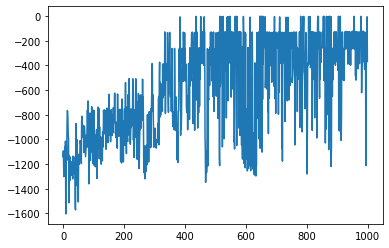

In [5]:
import gym

def main():

    max_episode_num = 1000
    env_name = 'Pendulum-v0'
    env = gym.make(env_name)
    agent = PPOagent(env)

    agent.train(max_episode_num)

    agent.plot_result()



if __name__=="__main__":
    main()

In [7]:
# PPO with GAE Load and Play

import gym

def main():

    env_name = 'Pendulum-v0'
    env = gym.make(env_name)
    agent = PPOagent(env)

    agent.actor.load_weights('./save_weights/')
    agent.critic.load_weights('./save_weights/')

    time = 0
    state = env.reset()

    while True:
        env.render()
        action = agent.actor.predict(state)
        state, reward, done, _ = env.step(action)
        time += 1

        print('Time: ', time, 'Reward: ', reward)

        if done:
            break

    env.close()

if __name__=="__main__":
    main()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 64)           256         input_7[0][0]                    
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 32)           2080        dense_27[0][0]                   
__________________________________________________________________________________________________
dense_29 (Dense)                (None, 16)           528         dense_28[0][0]                   
______________________________________________________________________________________